[![](https://bytebucket.org/davis68/resources/raw/f7c98d2b95e961fae257707e22a58fa1a2c36bec/logos/baseline_cse_wdmk.png?token=be4cc41d4b2afe594f5b1570a3c5aad96a65f0d6)](http://cse.illinois.edu/)

# Distributed Programming for Engineers (MPI)

<a id='contents'></a>
## Contents
- [Distributed Programs](#intro)
- [Background](#bkgd)
    - [SIMD](#simd)
    - [MIMD](#mimd)
- [Basics](#basics)
    - [Hello World](#hello)
    - [Message Passing](#msgpass)
    - [Collective Operations](#collect)
- [A Finite Difference Example](#fd)
    - [Nonblocking Message Passing](#msgpassi)
    - [Collective Operations 2](#collect2)
- [Scaling](#scaling)
- [Memory and C99-Style Variable-Length Arrays](#mem)
- [Passing Vectors](#vector)
- [Resources](#res)
    - [Where to Go Next](#wherenext)
- [Credits](#credits)

---
<a id='intro'></a>
## Distributed Programs
[MPI](http://www.mcs.anl.gov/research/projects/mpi/) is a library specification describing a parallel programming paradigm suitable for use on distributed-memory machines, such as modern supercomputers and distributed clusters.

In this lesson, we will review parallel programming concepts and introduce several useful MPI functions and concepts.  We will work within this [IPython](ipython.org)/[Jupyter](jupyter.org) notebook, which allows us to lay out our code, results, and commentary in the same interface.  Feel free to open up a `bash` shell in the background if you prefer to look at and execute your code that way.

Don't forget to load mpich or openmpi on the UIUC EWS workstations first:

```bash
    module load mpich2 # or openmpi if you prefer
```

---
<a id='bkgd'></a>
## Background:  Parallel Programming Paradigms

To better contextualize this, let us briefly review the basic parallel computing models in use today.

### Computer Architecture

A classical computer processor receives instructions as sets of binary data from memory and uses these instructions (in assembly language) to manipulate data from memory in predictable ways.  A processor works on a single piece of data at a time (although other data units may be waiting in the registers or cache) and executes a single thread, or sequential list, of commands on the data.

Thus we may say that a conventional desktop computer is SISD—*S*ingle *I*nstruction, *S*ingle *D*ata:  a single program operates on a single data element sequentially, then exchanges it back into memory and retrieves a new datum.  Any apparent multitasking is due to the operating system periodically switching the CPU's context from one thread to another.  We will represent this scenario in the following graphic, which shows a single processor interacting via a _bus_ (the wavy black band) with a collection of memory chips (which can be RAM, ROM, hard drives, etc.).

![](https://raw.githubusercontent.com/maxim-belkin/hpc-sp16/gh-pages/lessons/mpi/img/SISD-base.png)


<a id='simd'></a>
### SIMD—*S*ingle *I*nstruction, *M*ultiple *D*ata

Springboarding off of SISD, perhaps the simplest way to think about a way of parallel programming is the SIMD model—for instance, this is what you may have seen in the OpenMP lesson.  In this model, multiple processing units operate simultaneously on multiple pieces of data _in the same way_.

Consider, for instance, the addition of two eight-element vectors.  If we have eight processors available, then each processor can add two corresponding elements from the two vectors directly; the program then yields an efficiently added single eight-element vector afterwards (if we assume little to no overhead costs for the _vectorization_ of the program).

![](https://raw.githubusercontent.com/maxim-belkin/hpc-sp16/gh-pages/lessons/mpi/img/SIMD-vector-add.png)

(This, incidentally, was the major advantage of the first Cray supercomputers in the late 1970s:  vectorization let them operate on many data elements simultaneously, thus achieving stupendous speedups.)


<a id='mimd'></a>
### MIMD—*M*ultiple *I*nstruction, *M*ultiple *D*ata

Now it's not a major leap to think about using each of those processors to do something _different_ to their assigned data element.  It may not make much sense with vector addition, but when performing more complex operations like finite element differential equation solution or Monte Carlo random number integration, we often want a lot of plates spinning.

For MIMD to be effective, we need two different kinds of parallelism:  data-level parallelism (can I segment my problem domain into complementary parts, whether in real space, time, or phase space?); and control-level parallelism (do I need different parts of my program to execute differently based on the data they have allotted to them?).

Imagine trying to calculate $\pi$ by throwing darts at a circle.  We can count the number of darts that hit within the radius of the circle, $n_{\text{circle}}$, and compare that value with the ratio of all darts within a bounding square, $n_{\text{square}}$.  (Physical simulation of this process is left as an exercise to the reader.)  As we know the equations defining area, we can obtain $\pi$ trivially:
$$\begin{array}{l} A_\text{circle} = \pi r^2 \\ A_\text{square} = 4 r^2 \end{array} \implies r^2 = \frac{A_\text{square}}{4} = \frac{A_\text{circle}}{\pi} \implies \pi \approx 4 \frac{n_\text{circle}}{n_\text{square} + n_\text{circle}} \text{.}$$

![](https://raw.githubusercontent.com/maxim-belkin/hpc-sp16/gh-pages/lessons/mpi/img/darts.png)

It is apparent how this algorithm can benefit from parallelization:  since any one dart is thrown independently of the others, we are not restricted from throwing a large number simultaneously.  One possible algorithm could look like this:

    initialize_memory
    parallel {
        throw_dart
        total_darts = total_darts + 1
        count_my_darts_in_circle
    }
    add_all_darts_in_circle
    add_all_darts
    pi = 4 * darts_in_circle / total_darts

As you can see, in the parallel portion it doesn't matter to one processor what any other processor is doing.  The only time we need all of the processors in sync is at the end of the parallel section where we add up all the darts thrown and that hit the circle.  (We will return to this point later.)

Let's take a look at the architecture of MIMD machines in a bit more detail now.  The major division in MIMD programming is shared-memory _v._ distributed-memory systems.


**Shared-Memory Systems**

If the system architecture allows any processor to directly access any location in global memory space, then we refer to the machine as having a _shared memory_.  This is convenient in practice for the programmer but can lead to inefficiencies in hardware and software library design.  For instance, scaling beyond 32 or 64 processors has been a persistent problem for this architecture choice (contrast tens of thousands of processors for well-designed distributed-memory systems).

Examples of shared-memory parallelization specifications and libraries include [OpenMP](http://www.openmp.org/) and [OpenACC](http://www.openacc.org/).

![](https://raw.githubusercontent.com/maxim-belkin/hpc-sp16/gh-pages/lessons/mpi/img/MIMD-SM-base.png)

Addressing the dart-throwing problem above in the shared-memory paradigm is trivial, since each process can contribute its value from its unique memory location to the final result (a process known as _reduction_).

**Distributed-Memory Systems**

For distributed-memory MIMD architectures, every processor is alloted its own physical memory and has no knowledge of other processors' memory.  This is the classic problem which MPI was designed to address:  we now have to coördinate and communicate data across an internal network to allow these processors to work effectively together.

![](https://raw.githubusercontent.com/maxim-belkin/hpc-sp16/gh-pages/lessons/mpi/img/MIMD-DM-base.png)

The dart-throwing example from before is now nontrivial, but completely scalable (subject to communication overhead).  Every processor is independent and can calculate for one or many darts thrown.  However, some sort of reduction must be performed to obtain a final coherent result for the number of darts within the circle (the total number should be known _a priori_ from the number of processes, presumably).  The pseudocode in this case looks more like this:

    initialize_memory
    parallel {
        throw_dart
        total_darts = total_darts + 1
        count_my_darts_in_circle
    }
    darts_in_circle = reduction_over_all_processors_of_darts_in_their_circles
    add_all_darts
    pi = 4 * darts_in_circle / total_darts

We will shortly examine this case as implemented in MPI.

---
<a id='basis'></a>
## Basics

<a id='hello'></a>
### Hello World

The classical example for any new programming language or library is to construct a nontrivial "Hello World!" program.  In the following code (`./src/mpi-mwe/c/hello_world_mpi.c`), we will see the basic elements of any MPI program, including preliminary setup, branching into several processes, and cleanup when program execution is about to cease.  (No message passing occurs in this example.)

In [1]:
%%file hello_world_mpi.c
#include <stdio.h>
#include <mpi.h>

int main(int argc, char *argv[]) {
    int     rank_id, ierr, num_ranks;
    double  start_time, wall_time;
    
    printf("C MPI minimal working example\n");
    
    ierr = MPI_Init(&argc, &argv);
    start_time = MPI_Wtime();
    ierr = MPI_Comm_size(MPI_COMM_WORLD, &num_ranks);
    ierr = MPI_Comm_rank(MPI_COMM_WORLD, &rank_id);
    
    if (rank_id == 0) {
        printf("Number of available processors = %d.\n", num_ranks);
    }
    printf("\tProcess number %d branching off.\n", rank_id);
    
    wall_time = MPI_Wtime() - start_time;
    
    if (rank_id == 0) {
        printf("Elapsed wallclock time = %8.6fs.\n", wall_time);
    }
    
    MPI_Finalize();
    return 0;
}

Overwriting hello_world_mpi.c


Let’s compile and execute this program before commenting on its contents.  In order to link the program properly, there are a number of MPI libraries and include files which need to be specified.  Fortunately, a convenient wrapper around your preferred C/C++/Fortran compiler has been provided:  in this case, `mpicc`.  To see what the wrapper is doing behind the scenes, use the `-show` option:

    $ mpicc -show
    clang -I/usr/local/Cellar/open-mpi/1.8.1/include
          -L/usr/local/opt/libevent/lib
          -L/usr/local/Cellar/open-mpi/1.8.1/lib -lmpi

We can thus compile and execute the above example by simply entering,

    $ mpicc -o hello_world_mpi hello_world_mpi.c
$ ./hello_world_mpi
    C MPI minimal working example
    Number of available processors = 1.
        Process number 0 branching off.
    Elapsed wallclock time = 0.000270s.


In [2]:
!mpicc -o hello_world_mpi hello_world_mpi.c
!./hello_world_mpi

C MPI minimal working example
Number of available processors = 1.
	Process number 0 branching off.
Elapsed wallclock time = 0.000042s.


Now, that's not right, is it?  I have a number of processors on my modern machine, so why didn't this use them?  In the case of MPI, it is necessary to use the script `mpiexec` which sets up the copies in parallel and coördinates message passing.

In [3]:
!mpiexec ./hello_world_mpi

C MPI minimal working example
C MPI minimal working example
	Process number 1 branching off.
Number of available processors = 2.
	Process number 0 branching off.
Elapsed wallclock time = 0.000021s.


    $ mpiexec ./hello_world_mpi
    C MPI minimal working example
    C MPI minimal working example
    C MPI minimal working example
    C MPI minimal working example
        Process number 1 branching off.
    Number of available processors = 4.
        Process number 0 branching off.
    Elapsed wallclock time = 0.000021s.
        Process number 2 branching off.
        Process number 3 branching off.

(Note the _race conditions_ apparent here:  with input and output, unless you explicitly control access and make all of the threads take turns, the output order is unpredictable.)

Okay, let's step back and analyze the program now, noting the following points:
- MPI functions pass values by reference.
- MPI functions do not return the value of the variable they modify, but rather an error code.  The modified value is in the referenced variable.
- A universal communicator, `MPI_COMM_WORLD`, is defined to permit communication with all processes.  (Subsets of this may be defined as desired.)
- `MPI_Init` and `MPI_Finalize` must be called to initialize and terminate the message-passing environment.

### Exercise
- Run the "Hello World" script with 1, 2, 4, 8, and 16 processes.  See if the time required varies significantly.  Try this with other numbers as well:  3, 7, etc.

In [4]:
!mpiexec -np 8 ./hello_world_mpi

C MPI minimal working example
C MPI minimal working example
C MPI minimal working example
C MPI minimal working example
C MPI minimal working example
C MPI minimal working example
C MPI minimal working example
C MPI minimal working example
Number of available processors = 8.
	Process number 0 branching off.
Elapsed wallclock time = 0.000034s.
	Process number 4 branching off.
	Process number 1 branching off.
	Process number 3 branching off.
	Process number 5 branching off.
	Process number 7 branching off.
	Process number 6 branching off.
	Process number 2 branching off.


<a id='msgpass'></a>
### Message Passing:  `MPI_Send`, `MPI_Recv`

At the highest level, an MPI implementation supports the parallel execution of a number of copies of a program which can intercommunicate with each other across an equal number of processors.  Internode and intranode communications are implicitly handled by the operating system, interconnect, and MPI libraries.

The fundamental pair of actions for a processor using MPI is _sending_ and _receiving_ messages.  (This is also known as _point-to-point communication_.)  A number of more complex actions, such as the partitioning of data or collection of calculated results, are built from these point-to-point communications.  Finally, more advanced features exist to customize the processor topology, operations, and process management.

![](https://raw.githubusercontent.com/maxim-belkin/hpc-sp16/gh-pages/lessons/mpi/img/MPI-Send-Recv.png)

Send and receive actions are always paired with each other.  There are a number of flavors, but let's start with the basic two:  `MPI_Send` and `MPI_Recv`.  The function prototypes are:

    int MPI_Send(
        void*        message,          // Pointer to data to send
        int          count,            // Number of data values to send
        MPI_Datatype datatype,         // Type of data (e.g. MPI_INT)
        int          destination_rank, // Rank of process to receive message
        int          tag,              // Identifies message type
        MPI_Comm     comm              // Use MPI_COMM_WORLD
    )
    
    int MPI_Recv(
        void*        message,     // Points to location in memory where
                                  //     received message is to be stored.
        int          count,       // MAX number of data values to accept 
        MPI_Datatype datatype     // Type of data (e.g. MPI_INT)  
        int          source_rank, // Rank of process to receive from
                                  //    (Use MPI_ANY_SOURCE to accept
                                  //     from any sender)
        int          tag,         // Type of message to receive
                                  //    (Use MPI_ANY_TAG to accept any type)
        MPI_Comm     comm,        // Use MPI_COMM_WORLD
        MPI_Status*  status       // To receive info about the message
    )

There's a lot of information there, and none of it optional (if you want to hide it, use a language and package such as Python and [MPI4Py](mpi4py.scipy.org)).  Let's unpack the arguments a little more with a trivial example that implements the previous dart-throwing example.

In [5]:
%%file darts_pi.c
#include <math.h>
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <mpi.h>

#define N 100000
#define R 1

double uniform_rng() { return (double)rand() / (double)RAND_MAX; } // Not great but not the point of this exercise.

int main(int argc, char *argv[]) {
    int     rank_id, ierr, num_ranks;
    MPI_Status status;
    
    ierr = MPI_Init(&argc, &argv);
    ierr = MPI_Comm_size(MPI_COMM_WORLD, &num_ranks);
    ierr = MPI_Comm_rank(MPI_COMM_WORLD, &rank_id);
    srand(time(NULL) + rank_id);
    
    //  Calculate some number of darts thrown into the circle.
    int n_circle = 0;
    double x, y;
    for (int t = 0; t < N; t++) {
        x = uniform_rng();
        y = uniform_rng();
        if (x*x + y*y < (double)R*R) n_circle++;
    }
    
    //  If this is the first process, then gather everyone's data.  Otherwise, send it to the first process.
    int total_circle[num_ranks]; // C99 Variable Length Arrays; compile with `-std=c99` or else use `malloc`.
    if (rank_id == 0) {
        total_circle[0] = n_circle;
        for (int i = 1; i < num_ranks; i++) {
            ierr = MPI_Recv(&total_circle[i], 1, MPI_INT, i, MPI_ANY_TAG, MPI_COMM_WORLD, &status);
            //printf ("\t%d: recv %d from %d\n", rank_id, total_circle[i], i);
        }
    } else {
        ierr = MPI_Send(&n_circle, 1, MPI_INT, 0, 1, MPI_COMM_WORLD);
        //printf ("\t%d: send %d to %d\n", rank_id, n_circle, 0);
    }
    
    //  Now sum over the data and calculate the approximation of pi.
    int total = 0;
    if (rank_id == 0) {
        for (int i = 0; i < num_ranks; i++) {
            total += total_circle[i];
        }
        printf("With %d trials, the resulting approximation to pi = %f.\n", num_ranks*N, 4.0*(double)total/((double)N*(double)num_ranks));
    }
    
    MPI_Finalize();
    return 0;
}

Overwriting darts_pi.c


Compile and execute this code in the shell:

    $ mpicc -std=c99 -o darts_pi darts_pi.c
$ mpiexec -n 4 ./darts_pi 
    With 400000 trials, the resulting approximation to pi = 3.137710.
    Elapsed wallclock time = 0.002829s.

A few remarks:
- **We know this algorithm is inefficient**:  400,000 trials for 2 digits of accuracy is absurd!  Compare a series solution, which should give you that in a handful of terms.
- I don't do a great job of **calculating the random values as floating-point values**, just dividing by the maximum possible integer value from `stdlib.h`.  (This example is doubly dangerous in that it assumes that the default C random number library is thread safe!  **It is not!**—more on that in the OpenMP lesson.)
- Note how we are **accessing the respective elements of the array** `total_circle` in the `MPI_Recv` clause.
- We **limit the efficiency** by receiving the messages in order.

In [6]:
# To run this code from within the notebook.
!mpicc -std=c99 -o darts_pi darts_pi.c
!mpiexec -n 4 ./darts_pi

With 400000 trials, the resulting approximation to pi = 3.142390.


<a id='collect'></a>
### Collective Operations:  `MPI_Reduce`

We can render this function much more readable and less error-prone by using the convenience function `MPI_Reduce`, which achieves the same effective outcome as the prior code without the explicit message management.  Reduction takes a series of values from each processor, applies some operation to them, and then places the result on the root process (which doesn't have to be `0`, although it often is).

![](https://raw.githubusercontent.com/maxim-belkin/hpc-sp16/gh-pages/lessons/mpi/img/MPI-Reduce.png)

    int MPI_Reduce(
        void*        value,      // Input value from this process
        void*        answer,     // Result -- on root process only
        int          count,      // Number of values -- usually 1
        MPI_Datatype datatype,   // Type of data (e.g. MPI_INT)         
        MPI_Op       operation,  // What to do (e.g. MPI_SUM)           
        int          root,       // Process that receives the answer    
        MPI_Comm     comm        // Use MPI_COMM_WORLD                  
    )

In the context of our prior code, we can convert the code segment as follows:

In [7]:
%%file darts_pi.c
#include <math.h>
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <mpi.h>

#define N 100000
#define R 1

double uniform_rng() { return (double)rand() / (double)RAND_MAX; } // Not good but not the point of this exercise.

int main(int argc, char *argv[]) {
    int     rank_id, ierr, num_ranks;
    MPI_Status status;
    
    ierr = MPI_Init(&argc, &argv);
    ierr = MPI_Comm_size(MPI_COMM_WORLD, &num_ranks);
    ierr = MPI_Comm_rank(MPI_COMM_WORLD, &rank_id);
    srand(time(NULL) + rank_id);
    
    //  Calculate some number of darts thrown into the circle.
    int n_circle = 0;
    double x, y;
    for (int t = 0; t < N; t++) {
        x = uniform_rng();
        y = uniform_rng();
        if (x*x + y*y < (double)R*R) n_circle++;
    }
    
    //  Reduce by summation over all data and output the result.
    int total;
    ierr = MPI_Reduce(&n_circle, &total, 1, MPI_INT, MPI_SUM, 0, MPI_COMM_WORLD);
    if (rank_id == 0) {
        printf("With %d trials, the resulting approximation to pi = %f.\n", num_ranks*N, 4.0*(double)total/((double)N*(double)num_ranks));
    }
    
    MPI_Finalize();
    return 0;
}

Overwriting darts_pi.c


In [8]:
# To run this code from within the notebook.
!mpicc -std=c99 -o darts_pi darts_pi.c
!mpiexec -n 4 ./darts_pi

With 400000 trials, the resulting approximation to pi = 3.142430.


That reduces ten significant lines of code, two `for` loops, $N_\text{processor}$ MPI function calls, and an array allocation to a single MPI function call.  Not bad.  This is typical, I find, of numerical codes:  well-written MPI code in a few key locations covers the bulk of your communication needs, and you rarely need to explicitly pass messages or manage processes dynamically.

---
<a id='fd'></a>
## A Finite Difference Example

Let's look through an integrated example which will introduce a few new functions and give you a feel for how MPI operates in a larger code base.  We will utilize the finite difference method to solve Poisson's equation for an electrostatic potential:
$${\nabla}^2 \varphi = -\frac{\rho_f}{\varepsilon}$$
where $\rho_f$ are the (known) positions of charges; $\varepsilon$ is the permittivity of the material; and $\varphi$ is the resultant scalar electric potential field.

We use a second-order central difference scheme in the discretization of the differential equation in space and take an initial guess which will require iteration to obtain a steady-state solution.  The resulting equation for an arbitrary location in the $(x, y)$ grid (assuming uniform discretization) subject to a set of discrete point charges $\sum \rho_f$ is:
$$\frac{\varphi_{i+1,j}-2\varphi_{i,j}+\varphi_{i-1,j}}{\delta^2} + \frac{\varphi_{i,j+1}-2\varphi_{i,j}+\varphi_{i,j-1}}{\delta^2} = \frac{\sum \rho_f}{\varepsilon} \implies$$
$$\varphi_{i,j} = \frac{1}{4} \left(\varphi_{i+1,j}+\varphi_{i-1,j}+\varphi_{i,j+1}+\varphi_{i,j-1}\right) - \frac{\Delta^2}{4} \left(\frac{\sum \rho_f}{\varepsilon}\right) \text{.}$$
(As the discretization does not subject grid locations to nonlocal influences, it is necessary for the grid locations next to the point charges to propagate that information outward as the iteration proceeds towards a solution.)

For some known distribution of charges, we can construct a matrix equation and solve it appropriately either by hand-coding an algorithm or by using a library such as [GNU Scientific Library](https://www.gnu.org/software/gsl/).  In this case, to keep things fairly explicit, we won't write a matrix explicitly and will instead solve each equation in a `for` loop.


**Serial Code**

One of the odd things we need to consider is that because we are using point charges our grid has to overlap with them directly.  (This isn't as much of a problem with distributions.)  So we'll just start with a handful of point charges for now, with the boundaries from $(-1,-1)$ to $(1,1)$ set to zero.

In [9]:
%%file fd_charge.c
//  This is a serial version of the code for reference.
#include <math.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h> //for memcpy()
#include <time.h>

#define BOUNDS 1.0

double uniform_rng() { return (double)rand() / (double)RAND_MAX; } // Not good but not the point of this exercise.
struct point_t { int x, y; double mag; };

int main(int argc, char *argv[]) {
    int N = 10;
    if (argc > 1) N = atoi(argv[1]);
    int size = N % 2 == 0 ? N : N+1;  // ensure odd N
    int iter = 10;
    if (argc > 2) iter = atoi(argv[2]);
    int out_step = 1000;
    if (argc > 3) out_step = atoi(argv[3]);
    double eps = 8.8541878176e-12; // permittivity of the material
    srand(time(NULL));
    
    //  Initialize the grid with an initial guess of zeros as well as the coordinates.
    double phi[size][size];    // C99 Variable Length Arrays; compile with `-std=c99` or else use `malloc`.
    double oldphi[size][size];
    double x[size],
           y[size];
    double dx = (2*BOUNDS)/size,
           dy = dx;
    for (int i = 0; i < size; i++) {
        x[i] = (double)i*dx - BOUNDS;
        for (int j = 0; j < size; j++) {
            if (i == 0) y[j] = (double)j*dy - BOUNDS;
            phi[i][j] = 0.0;
        }
    }
    //  Set up a few random points and magnitudes for the electrostatics problem.
    int K = 20;
    struct point_t pt_srcs[K];
    for (int k = 0; k < K; k++) {
        pt_srcs[k].x   = (int)(uniform_rng() * N);
        pt_srcs[k].y   = (int)(uniform_rng() * N);
        pt_srcs[k].mag = uniform_rng() * 2.0 - 1.0;
        printf("(%f, %f) @ %f\n", x[pt_srcs[k].x], y[pt_srcs[k].y], pt_srcs[k].mag);
    }
    
    //  Iterate forward.
    int    n_steps = 0;        // total number of steps iterated
    double inveps = 1.0 / eps; // saves a division every iteration over the square loop
    double pt_src = 0.0;       // accumulator for whether a point source is located at a specific (i,j) index site
    while (n_steps < iter) {
        memcpy(oldphi, phi, size*size);
        for (int i = 0; i < size; i++) {
            for (int j = 0; j < size; j++) {
                //  Calculate point source contributions.
                pt_src = 0;
                for (int k = 0; k < K; k++) {
                    pt_src = pt_src + ((pt_srcs[k].x == i && pt_srcs[k].y == j) ? pt_srcs[k].mag : 0.0);
                }
                phi[i][j] = 0.25*dx*dx * pt_src * inveps
                          + 0.25*(i == 0      ? 0.0 : phi[i-1][j])
                          + 0.25*(i == size-1 ? 0.0 : phi[i+1][j])
                          + 0.25*(j == 0      ? 0.0 : phi[i][j-1])
                          + 0.25*(j == size-1 ? 0.0 : phi[i][j+1]);
            }
        }
        if (n_steps % out_step == 0) {
            printf("Iteration #%d:\n", n_steps);
            printf("\tphi(%f, %f) = %24.20f\n", x[(int)(0.5*N-1)], y[(int)(0.25*N+1)], phi[(int)(0.5*N-1)][(int)(0.25*N+1)]);
        }
        n_steps++;
    }
    
    //  Write the final condition out to disk and terminate.
    printf("Terminated after %d steps.\n", n_steps);
    
    FILE* f;
    f = fopen("./data.txt", "w"); // wb -write binary
    if (f != NULL) {
        for (int i = 0; i < size; i++) {
            for (int j = 0; j < size; j++) {
                fprintf(f, "%f\t", phi[i][j]);
            }
            fprintf(f, "\n");
        }
        fclose(f);
    } else {
        //failed to create the file
    }

    return 0;
}


Overwriting fd_charge.c


In [10]:
!gcc -std=c99 -o fd_charge fd_charge.c
!./fd_charge 200 30000 1000

(0.460000, 0.750000) @ -0.018925
(-0.080000, -0.840000) @ -0.188539
(-0.790000, 0.360000) @ -0.480071
(-0.560000, 0.510000) @ -0.950878
(0.600000, -0.660000) @ -0.072830
(-0.060000, 0.190000) @ -0.527965
(0.480000, -0.150000) @ 0.526914
(-0.150000, -0.660000) @ -0.609086
(-0.920000, -0.550000) @ 0.930034
(-0.920000, 0.850000) @ -0.785373
(0.220000, 0.690000) @ -0.588163
(0.750000, -0.810000) @ -0.006712
(-0.810000, -0.320000) @ 0.125744
(-0.630000, 0.780000) @ 0.674575
(-0.420000, 0.740000) @ -0.277308
(-0.720000, -0.760000) @ 0.465527
(0.100000, 0.290000) @ 0.815238
(-0.300000, 0.360000) @ 0.510200
(0.920000, 0.520000) @ -0.429569
(0.220000, 0.440000) @ -0.355375
Iteration #0:
	phi(-0.010000, -0.490000) =  -0.00009889063898437276
Iteration #1000:
	phi(-0.010000, -0.490000) = -626523.07082846970297396183
Iteration #2000:
	phi(-0.010000, -0.490000) = -832562.87276508682407438755
Iteration #3000:
	phi(-0.010000, -0.490000) = -887221.51111481385305523872
Iteration #4000:
	phi(-0.010000, -

/Users/mbelkin/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


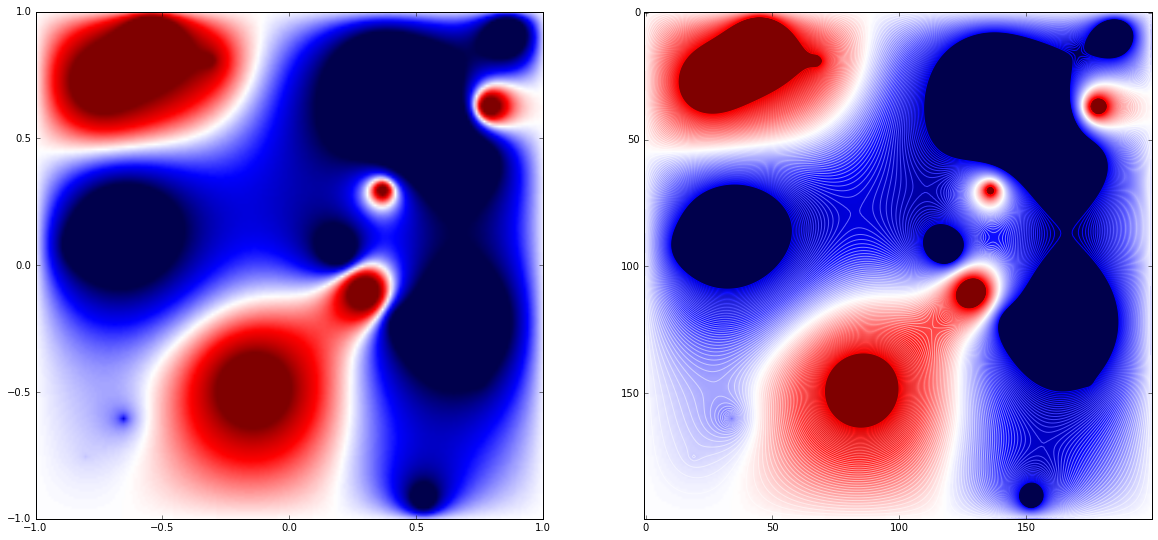

In [11]:
# Use Python to visualize the result quickly.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
#mpl.rcParams['figure.figsize']=[20,20]

data = np.loadtxt('./data.txt')
grdt = np.gradient(data);
mx = 10**np.floor(np.log10(data.max()))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
axes[0].imshow(data, cmap=cm.seismic, vmin=-mx, vmax=mx, extent=[-1,1,-1,1])
axes[1].imshow(data, cmap=cm.seismic, vmin=-mx, vmax=mx)
axes[1].contour(data, cmap=cm.bwr, vmin=-mx, vmax=mx, levels=np.arange(-mx,mx+1,(2*mx)/1e2))
fig.show()

So for a quick and dirty job (and no validation or verification of the numerics), that serial code will do.  But you can already notice significant slowdown towards convergence even at 400×400 resolution (0.025 length units).  To handle bigger problems, it will be necessary to parallelize.

**Parallel Code**

We will restrict the domain decomposition to two adjoining processes for the sake of pedagogy, although you likely wouldn't be this restrictive in a real code.  Each processor will be responsible for calculating the electrostatics on its segment of the domain, and will not actually have access to the values calculated by the other processes unless they are explicitly communicated.

<table>
<tr>
<td><img src="https://raw.githubusercontent.com/maxim-belkin/hpc-sp16/gh-pages/lessons/mpi/img/decomp-2.png"/> <p>One possible decomposition of a domain by area and processor.<br/>This was used in the code below (with two processes).</p></td>
<td><img src="https://raw.githubusercontent.com/maxim-belkin/hpc-sp16/gh-pages/lessons/mpi/img/decomp-1.png"/> <p>An alternative, more local, decomposition appropriate<br/> for nearest-neighbor calculations.</p></td>
</tr>
</table>

Why would we need to communicate any values?  Well, in this case, parallelization is nontrivial:  the finite difference algorithm is nearest-neighbor based, so with a spatial decomposition of the domain we will still need to communicate boundary cells to neighboring processes.  Thus we will require _ghost cells_, which refer to data which are not located on this processor natively but are retrieved and used in calculations on the boundary of the local domain.

![](https://raw.githubusercontent.com/maxim-belkin/hpc-sp16/gh-pages/lessons/mpi/img/ghost-cells.png)

We can set these up either by having separate arrays for the ghost cells (which leads to clean messaging but messy numerical code) or having integrated arrays in the main `phi` array (which leads to nasty messaging code but nicer numerics).  We will use clean messaging to clarify the message passing aspect at the cost of obfuscating the numerics a bit with nested ternary cases.

In [16]:
%%file fd_charge.c
//  This is a parallel version of the code.  The domain consists of a column of square domains abutting each other.
#include <math.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h> //for memcpy()
#include <time.h>
#include <mpi.h>

#define BOUNDS 1.0

double uniform_rng() { return (double)rand() / (double)RAND_MAX; } // Not good but not the point of this exercise.
struct point_t { int x, y; double mag; };

int main(int argc, char *argv[]) {
    //  Get number of discrete steps along domain.
    int size = 50;
    if (argc > 1) size = atoi(argv[1]);
    
    //  Get number of iterations to use in solver.
    int iter = 10000;
    if (argc > 2) iter = atoi(argv[2]);
    
    //  Get interval for output of test value in convergence.
    int out_step = iter/10;
    if (argc > 3) out_step = atoi(argv[3]);
    
    double eps = 8.8541878176e-12; // permittivity of the material
    
    int     rank_id, ierr, num_ranks;
    MPI_Status  status;
    MPI_Request request;
    
    ierr = MPI_Init(&argc, &argv);
    ierr = MPI_Comm_size(MPI_COMM_WORLD, &num_ranks);
    ierr = MPI_Comm_rank(MPI_COMM_WORLD, &rank_id);
    srand(time(NULL) + rank_id);
    
    //  We will restrict the domain (and thus processes) to only two neighboring processes for the sake of pedagogy.
    if (num_ranks != 2) {
        printf("Expected 2 processes; actual number of processes %d.\n", num_ranks);
        MPI_Abort(MPI_COMM_WORLD, MPI_ERR_OTHER);
        return 0;
    }
    
    //  Calculate the processor grid preparatory to the domain partition.  We'll make the assignment into a
    //  2 x 1 array, making determination of neighboring processes trivial.
    int nbr_t, nbr_b;
    if (rank_id == 0) {
        nbr_t = -1;
        nbr_b =  1;
    } else {
        nbr_t =  0;
        nbr_b = -1;
    }
    
    //  Initialize the _local_ grid with an initial guess of zeros as well as the coordinates.  We will keep each
    //  local domain the same size as the original domain, 2x2 in coordinates, and just translate them to make a
    //  larger domain---in this case, adding processes increases the domain size rather than the mesh resolution.
    double phi[size][size];     // potential grid---compile with `-std=c99` or else use `malloc`.
    double x[size],             // x-domain vector
           y[size];             // y-domain vector
    double dx = (2*BOUNDS)/size,// increment in x-direction
           dy = dx;             // increment in y-direction
    double base_x = -BOUNDS,                            // [-1,1) for both processes
           base_y = 2*BOUNDS*(rank_id % 2) - BOUNDS*2;  // [-2,0) for process 0; [0,2) for process 1
    for (int i = 0; i < size; i++) {
        x[i] = (double)i*dx + base_x;
        for (int j = 0; j < size; j++) {
            if (i == 0) y[j] = (double)j*dy + base_y;
            phi[i][j] = 0.0;
        }
    }
    double phi_t_in[size], // ghost cell messaging arrays
           phi_b_in[size],
           phi_t_out[size],
           phi_b_out[size];
    for (int i = 0; i < size; i++) {
        phi_t_in[i]  = 0.0;
        phi_b_in[i]  = 0.0;
    }
    
    //  Set up a few random points and magnitudes for the electrostatics problem.
    int K = 10;
    struct point_t pt_srcs[K];
    for (int k = 0; k < K; k++) {
        (uniform_rng()); // demonstration that the RNG is bad:  without this the first number is the same on every process
        int x_rn = (int)(uniform_rng() * size);
        int y_rn = (int)(uniform_rng() * size);
        pt_srcs[k].x   = x_rn;
        pt_srcs[k].y   = y_rn;
        pt_srcs[k].mag = uniform_rng() * 2.0 - 1.0;
    }
    
    //  Iterate forward.
    int    n_steps = 0;        // total number of steps iterated
    double inveps = 1.0 / eps; // saves a division every iteration over the square loop
    double pt_src = 0.0;       // accumulator for whether a point source is located at a specific (i,j) index site
    while (n_steps < iter) {
        //  Propagate the matrix equation forward towards a solution.
        for (int i = 0; i < size; i++) {
            for (int j = 0; j < size; j++) {
                //  Calculate point source contributions.
                pt_src = 0;
                for (int k = 0; k < K; k++) {
                    pt_src = pt_src + ((pt_srcs[k].x == i && pt_srcs[k].y == j) ? pt_srcs[k].mag : 0.0);
                }
                phi[i][j] = 0.25*dx*dx * pt_src * inveps
                          + 0.25*(i == 0      ? 0.0 : phi[i-1][j])
                          + 0.25*(i == size-1 ? 0.0 : phi[i+1][j])
                          + 0.25*(j == 0      ? (nbr_b < 0 ? 0.0 : phi_b_in[i]) : phi[i][j-1])
                          + 0.25*(j == size-1 ? (nbr_t < 0 ? 0.0 : phi_t_in[i]) : phi[i][j+1]);
            }
        }
        
        //  Communicate the border cell information to neighboring processes.  We will alternate odd and even processes,
        //  although there are more sophisticated ways to do this with nonblocking message passing.  Why do we alternate?
        for (int i = 0; i < size; i++) {
            phi_t_out[i] = phi[i][size-1];
            phi_b_out[i] = phi[i][0];
        }
        //    Pass data up.
        if (nbr_t >= 0) MPI_Isend(phi_t_out, size, MPI_DOUBLE, nbr_t, 0,           MPI_COMM_WORLD, &request);
        if (nbr_b >= 0) MPI_Irecv(phi_b_in,  size, MPI_DOUBLE, nbr_b, MPI_ANY_TAG, MPI_COMM_WORLD, &request);
        
        //    Pass data down.
        if (nbr_b >= 0) MPI_Isend(phi_b_out, size, MPI_DOUBLE, nbr_b, 0,           MPI_COMM_WORLD, &request);
        if (nbr_t >= 0) MPI_Irecv(phi_t_in,  size, MPI_DOUBLE, nbr_t, MPI_ANY_TAG, MPI_COMM_WORLD, &request);
        
        MPI_Barrier(MPI_COMM_WORLD);
        
        //  Output information periodically.
        if (rank_id == 0 && n_steps % out_step == 0) {
            printf("Iteration #%d:\n", n_steps);
            printf("\tphi(%6.3f, %6.3f) = %24.20f\n", x[(int)(0.5*size-1)], y[(int)(0.25*size+1)], phi[(int)(0.5*size-1)][(int)(0.25*size+1)]);
        }
        n_steps++;
    }
    if (rank_id == 0) {
        printf("Terminated after %d steps.\n", n_steps);
        printf("\tphi(%6.3f, %6.3f) = %24.20f\n", x[(int)(0.5*size-1)], y[(int)(0.25*size+1)], phi[(int)(0.5*size-1)][(int)(0.25*size+1)]);
    }
    
    //  Write the final condition out to disk and terminate.
    //  Parallel I/O, while supported by MPI, is a whole other ball game and we won't go into that here.
    //  Thus we will gather all of the data to process rank 0 and output it from there.
    double phi_vector[size*2*size];
    //  We actually have to transpose each process's data into a column-major format to align properly.
    double phi_trans[size][size];
    for (int i = 0; i < size; i++) {
        for (int j = 0; j < size; j++) {
            phi_trans[size-j-1][i] = phi[i][j];
        }
    }
    MPI_Gather(&phi_trans[0][0], size*size, MPI_DOUBLE, &phi_vector[0], size*size, MPI_DOUBLE, 0, MPI_COMM_WORLD);
    //  At this point, the data are in one array on process rank 0 but not in a two-dimensional array, so fix that.
    double phi_new[size][size*num_ranks];
    int offset;
    for (int p = 0; p < num_ranks; p++) {     // source process for data
        offset = p*size;
        for (int i = 0; i < size; i++) {      // x-index of process data
            for (int j = 0; j < size; j++) {  // y-index of process data
                phi_new[offset+i][j] = phi_vector[p*size*size+i*size+j];
            }
        }
    }
    
    if (rank_id == 0) {
        FILE* f;
        char filename[16];
        f = fopen("data.txt", "w"); // wb -write binary
        if (f != NULL) {
            for (int i = 0; i < 2*size; i++) {
                for (int j = 0; j < size; j++) {
                    fprintf(f, "%f\t", phi_new[i][j]);
                }
                fprintf(f, "\n");
            }
            fclose(f);
        } else {
            //failed to create the file
        }
    }
    
    MPI_Finalize();
    return 0;
}


Overwriting fd_charge.c


In [13]:
!mpicc -std=c99 -o fd_charge fd_charge.c
!mpiexec -np 2 ./fd_charge 100 10001 1000

Iteration #0:
	phi(-0.020, -1.480) = 426.57886155588141718908
Iteration #1000:
	phi(-0.020, -1.480) = 5182744.34156714845448732376
Iteration #2000:
	phi(-0.020, -1.480) = 5561469.02030726987868547440
Iteration #3000:
	phi(-0.020, -1.480) = 5892373.02382216043770313263
Iteration #4000:
	phi(-0.020, -1.480) = 6105722.47694652434438467026
Iteration #5000:
	phi(-0.020, -1.480) = 6231236.52565353363752365112
Iteration #6000:
	phi(-0.020, -1.480) = 6302655.27766274753957986832
Iteration #7000:
	phi(-0.020, -1.480) = 6342666.34540291596204042435
Iteration #8000:
	phi(-0.020, -1.480) = 6364892.19263049028813838959
Iteration #9000:
	phi(-0.020, -1.480) = 6377175.61247516144067049026
Iteration #10000:
	phi(-0.020, -1.480) = 6383942.20682349614799022675
Terminated after 10001 steps.
	phi(-0.020, -1.480) = 6383942.20682349614799022675


/Users/mbelkin/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


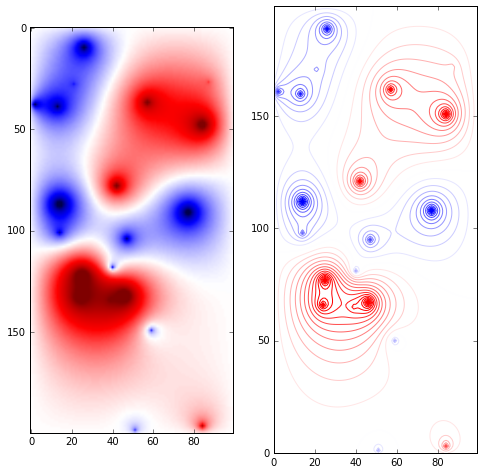

In [14]:
# Use Python to visualize the result quickly.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

data = np.loadtxt('./data.txt')
#mx = 10**np.floor(np.log10(data.max()))
mx = 0.5*data.max()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
axes[0].imshow( data,         cmap=cm.seismic, vmin=-mx, vmax=mx)
axes[1].contour(data[::-1,:], cmap=cm.bwr,     vmin=-mx, vmax=mx, levels=np.arange(-8*mx,8*mx,mx/10))
fig.show()

- What happens if you neglect to include the following conditional around the file output?


    if (rank_id == 0) { ... }

Domains naturally do not overlap in this case:

    0: (-2.00,-2.00)-(-0.01,-0.01)
    1: ( 0.00,-2.00)-( 1.99,-0.01)
    2: (-2.00, 0.00)-(-0.01, 1.99)
    3: ( 0.00, 0.00)-( 1.99, 1.99)

<a id='msgpassi'></a>
### Nonblocking Message Passing:  `MPI_Isend`, `MPI_Irecv`

The vanilla MPI send and receive operations are _blocking_, meaning that when you send a message the process waits at that point until an acknowledgment of receipt is sent by the receiving process.  As you can imagine, this both slows down your code and makes even simple messaging schemes cumbersome (what happens if you tell every process to send at the same time and receive at the next function call?).  In order to prevent this kind of deadlock, we use _nonblocking_ communications, which do not block execution—they just fire their message into the ether and proceed ahead.

As before, there are a lot of variants, but the basic two are `MPI_Isend` and `MPI_Irecv`.

    int MPI_Isend(
        void*        message,          // Pointer to data to send
        int          count,            // Number of data values to send
        MPI_Datatype datatype,         // Type of data (e.g. MPI_INT)
        int          destination_rank, // Rank of process to receive message
        int          tag,              // Identifies message type
        MPI_Comm     comm,             // Use MPI_COMM_WORLD
        MPI_Request* request           // To query about the status of the message
    )
    
    int MPI_Irecv(
        void*        message,     // Points to location in memory where
                                  //     received message is to be stored.
        int          count,       // MAX number of data values to accept 
        MPI_Datatype datatype     // Type of data (e.g. MPI_INT)  
        int          source_rank, // Rank of process to receive from
                                  //    (Use MPI_ANY_SOURCE to accept
                                  //     from any sender)
        int          tag,         // Type of message to receive
                                  //    (Use MPI_ANY_TAG to accept any type)
        MPI_Comm     comm,        // Use MPI_COMM_WORLD
        MPI_Request* request      // To query about the status of the message
    )

There's a lot of information there, and none of it optional.  Let's unpack the arguments a little more with a trivial example that implements the previous dart-throwing example.

<a id='collect2'></a>
### Collective Operations:  `MPI_Barrier`, `MPI_Gather`

Now, with nonblocking operations we can easily run into a situation where we need to know that a certain message has already been received in order to coherently progress:  the array needs to be updated, whatever.  In that case, `MPI_Barrier` defines a point at which all processes will wait until they are synchronized with each other again.  They slow code down, however, and so they should be used sparingly.

![](https://raw.githubusercontent.com/maxim-belkin/hpc-sp16/gh-pages/lessons/mpi/img/MPI-Barrier.gif)

    int MPI_Barrier(
        MPI_Comm     comm        // Use MPI_COMM_WORLD                  
    )

### Exercise

- What is the difference in the following two code snippets?


    //    Pass data left.
    if (nbr_l >= 0) MPI_Isend(phi_l_out, size, MPI_DOUBLE, nbr_l, 0,           MPI_COMM_WORLD, &request);
    if (nbr_r >= 0) MPI_Irecv(phi_r_in,  size, MPI_DOUBLE, nbr_r, MPI_ANY_TAG, MPI_COMM_WORLD, &request);
    if (nbr_l >= 0 && n_steps == 1000) printf("%d: %d sending left  %f to %d\n", n_steps, rank_id, phi_l_out[5], nbr_l);
    if (nbr_r >= 0 && n_steps == 1000) printf("%d: %d recving right %f of %d\n", n_steps, rank_id, phi_r_in[5], nbr_r);
    MPI_Barrier(MPI_COMM_WORLD);

    //    Pass data left.
    if (nbr_l >= 0) MPI_Isend(phi_l_out, size, MPI_DOUBLE, nbr_l, 0,           MPI_COMM_WORLD, &request);
    if (nbr_r >= 0) MPI_Irecv(phi_r_in,  size, MPI_DOUBLE, nbr_r, MPI_ANY_TAG, MPI_COMM_WORLD, &request);
    MPI_Barrier(MPI_COMM_WORLD);
    if (nbr_l >= 0 && n_steps == 1000) printf("%d: %d sending left  %f to %d\n", n_steps, rank_id, phi_l_out[5], nbr_l);
    if (nbr_r >= 0 && n_steps == 1000) printf("%d: %d recving right %f of %d\n", n_steps, rank_id, phi_r_in[5], nbr_r);


### `MPI_Gather`

Previously, we examined the function `MPI_Reduce`, which took data from every process, transformed them by some operation like addition or multiplication, and placed the result in a variable on `root`.  In the case above, we needed to gather data from every process _without_ transforming the data or collapsing it from an array to a single value.

`MPI_Gather` takes arrays from every process and combines them (by rank) into a new array on `root`.  The new array, as we saw above, is ordered by rank, meaning that if a different topology is in use you have to correct the data (which we did).

![](https://raw.githubusercontent.com/maxim-belkin/hpc-sp16/gh-pages/lessons/mpi/img/MPI-Gather-vec.png)

    int MPI_Gather(
        void*        sendbuf,    // Starting address of send buffer
        int          sendcnt,    // Number of elements in send buffer
        MPI_Datatype datatype,   // Type of data (e.g. MPI_INT)         
        void*        recvbuf,    // Starting address of receive buffer
        int          recvcnt,    // Number of elements for any single receive
        MPI_Datatype recvtype,   // Type of data (e.g. MPI_INT)         
        int          root,       // Process that receives the answer    
        MPI_Comm     comm        // Use MPI_COMM_WORLD                  
    )


In this case, MPI is a _lot_ more work, but you gain the capability of scaling to a reasonably large number of processors.


---
<a id='scaling'></a>
## Scaling

_Scaling_ refers to how efficiently your code retains performance as both the problem size $N$ and the number of processes $P$ increase.  It is typically divided into _weak_ and _strong_ scaling.

**Strong Scaling**:  How does the performance behave as the number of processors $P$ increases for a fixed total problem size $N$?

This is what most people think of as scaling, and describes the overall performance of a code as a problem is subdivided into smaller and smaller pieces between processes.  To test this, select a problem size suitable to scaling to a large number of processes (for instance, divisible by 64), and simply call larger and larger jobs while outputting timing information.

**Weak Scaling**:  How does the performance behave as the number of processors $P$ varies with each processor handling a fixed process size $N_P = N/P = \text{const}$?

In this case (which is most appropriate for $O(N)$ algorithms but can be used for any system ([ref](https://web.archive.org/web/20140307224104/http://www.stfc.ac.uk/cse/25052.aspx))), we observe more about the relative overhead incurred by including additional machines in the problem solution.  Weak scaling can be tested in a straightforward manner by keeping track of the pieces of the puzzle each process is responsible for.  With strongly decomposable systems, like molecular dynamics or PDE solution on meshes, weak scaling can be revealing.  However, in my experience there are many types of problems for which solving for $N$ and solving for $N+1$ are radically different problems, such as in density functional theory where the addition of an electron means the solution of a fundamentally different physical system.

---
<a id='mem'></a>
## Memory and C99 Variable-Length Arrays

Are the following two segments of code equivalent in C99?

**Snippet 1**

    int m = 5, n = 10, p = 7;
    double array[m][n][p];
    
**Snippet 2**

    double ***array;
    array = (double***) malloc(m*sizeof(double**));
    for (i = 0; i < m; i++) {
       array[i] = (double**) malloc(n*sizeof(double*));
       for (j = 0; j < n; j++) {
           array[i][j] = (double*) malloc(p*sizeof(double));
       }
    }

They _aren't_—but it's very subtle _why_.  The two snippets are _not_ equivalent from a memory standpoint because of where they allocate `array`:  the first allocates `array` on the stack, the second on the heap.

Application memory is conventionally divided into two regions:  the _stack_ and the _heap_.  For many applications it doesn't really matter which you use, but when you start defining very large arrays of data or using multiple threads in parallel then it can become critical to manage your memory well. ([ref1](https://stackoverflow.com/questions/79923/what-and-where-are-the-stack-and-heap)) ([ref2](https://stackoverflow.com/questions/22555639/mpi-communicate-large-two-dimensional-arrays))

- **Stack** memory is specific to a thread, and is generally fixed in size.  It is often faster to allocate in, and easier to read the allocation code.

- **Heap** memory is shared among all threads, and grows as demand requires.

C99 variable-length arrays (VLAs) allocate on the stack.  Since you can overflow the stack, VLAs are probably not a good idea for serious numeric code.  They do make code so much more readable that I opted for them in this lesson.


### Exercise
- Implement the parallel prefix sum algorithm depicted graphically above.  Feel free to copy code snippets from earlier to structure your code and then make it work.

In [15]:
%%file parprefix.c
// your code here

Overwriting parprefix.c


---
<a id='vectors'></a>
## Passing Vectors

MPI is designed to work straightforwardly with C-style arrays.  Oftentimes, however, we are working with more complex data types, such as objects or C++ STL `vector`s.  We can pass these between processes as well.

Recollect the format of the `MPI_Send` command:

    int MPI_Send(
        void*        message,          // Pointer to data to send
        int          count,            // Number of data values to send
        MPI_Datatype datatype,         // Type of data (e.g. MPI_INT)
        int          destination_rank, // Rank of process to receive message
        int          tag,              // Identifies message type
        MPI_Comm     comm              // Use MPI_COMM_WORLD
    )

A regular C-style array is sent thus:

    double array[5];
    MPI_Send(array, 5, MPI_DOUBLE, nbr, 0, MPI_COMM_WORLD);

You may thus hope that the following would work:

    std::vector<double> vector(5, 1.0);
    MPI_Send(vector, vector.size(), MPI_DOUBLE, nbr, 0, MPI_COMM_WORLD);

but it turns out that STL doesn't guarantee that the address of your `std::vector` object is the same as the start of the array of data it contains.  This stymied me once, so I'll let you in on the solution in cases like this:  you can address from the start of the array, `&vector[0]`.

    MPI_Send(&vector[0], vector.size(), MPI_DOUBLE, nbr, 0, MPI_COMM_WORLD);

---
<a id='res'></a>
## Resources

- [DeinoMPI documentation](http://mpi.deino.net/mpi_functions/).  The most complete and thorough documentation (with examples) of MPI-2 functions.

- [UMinn tutorial](http://static.msi.umn.edu/tutorial/scicomp/general/MPI/content1.html)

<a id='wherenext'></a>
### Where to go next

Where should you go next? Look into the [Training Roadmap at hpcuniversity](http://hpcuniversity.org/roadmap/) for an overview of HPC software development and usage—it covers a lot of gaps we inevitably left in our whirlwind tour of Campus Cluster. NICS at University of Tennessee also archives their [HPC seminar series](https://www.nics.tennessee.edu/hpc-seminar-series/). The [Parallel Computing Institute](http://parallel.illinois.edu/education) located here is a premier center for parallel computing research.  Finally, there are [a number of courses here](https://wiki.cites.illinois.edu/wiki/display/parcomp/Existing+Courses+in+Parallel+Computing) you can take as well to learn the theory of parallel computing:

-   ECE 408/CS 483 *Applied Parallel Programming*

-   ECE 492/CS 420/CSE 402 *Introduction to Parallel Programming for
    Scientists and Engineers*

-   ECE 428/CS 425/CSE 424 *Distributed Systems*

-   CS 524 *Concurrent Programming Languages*

-   CS 525 *Advanced Topics in Distributed Systems*

-   CS 533 *Parallel Computer Architectures*

-   CS 554/CSE 512 *Parallel Numerical Algorithms*

-   ECE 598HK/CS 598HK *Computational Thinking for Many-Core Computing*

-   Coursera—[High Performance Scientific Computing](https://www.coursera.org/course/scicomp)

---
<a id='credits'></a>
## Credits

Neal Davis developed these materials for [Computational Science and Engineering](http://cse.illinois.edu/) at the University of Illinois at Urbana–Champaign.

<img src="http://i.creativecommons.org/l/by/4.0/88x31.png" align="left">
This content is available under a [Creative Commons Attribution 4.0 Unported License](https://creativecommons.org/licenses/by/4.0/).

[![](https://bytebucket.org/davis68/resources/raw/f7c98d2b95e961fae257707e22a58fa1a2c36bec/logos/baseline_cse_wdmk.png?token=be4cc41d4b2afe594f5b1570a3c5aad96a65f0d6)](http://cse.illinois.edu/)

---
## List of MPI Functions
**Initialization & Cleanup**

`MPI_Init`

`MPI_Finalize`

`MPI_Abort`

`MPI_Comm_rank`

`MPI_Comm_size`

`MPI_COMM_WORLD`

`MPI_Wtime`

**Message Passing**

`MPI_Status`

`MPI_Probe`

**Point-to-Point**

We didn't discuss the mysterious "other" ways of sending messages mentioned earlier.  These are they—other modes include explicit buffering (`B`), ready sending (so a matching receive must have already posted) (`R`), and synchronous sending (best for efficiency) (`S`). ([ref](http://www.mcs.anl.gov/research/projects/mpi/sendmode.html))

`MPI_Send`

`MPI_Bsend`

`MPI_Ssend`

`MPI_Rsend`

`MPI_Isend`

`MPI_Ibsend`

`MPI_Irsend`



`MPI_Recv`

`MPI_Irecv`



`MPI_Sendrecv`

**Collective**

`MPI_Bcast`

`MPI_Gather`

`MPI_Scatter`

`MPI_Allgather x{v}`

`MPI_Allreduce`

`MPI_Alltoall x{w,v}`

x`MPI_Reduce_scatter`

x`MPI_Scan`



`MPI_Barrier`

**Advanced**

*Derived Datatypes and Operations*

`MPI_Pack`

`MPI_Type_vector`

`MPI_Type_contiguous`

`MPI_Type_commit`

`MPI_Type_free`



`MPI_Op_create`

`MPI_User_function`

`MPI_Op_free`

Robey’s [Kahan sum](http://www.sciencedirect.com/science/article/pii/S0167819111000238)



`MPI_Comm_create`

`MPI_Scan`

`MPI_Exscan`

`MPI_Comm_free`

**I/O**

`MPI_File_*`

**One-Sided Communication**
MPI_Put         write to remote memory
MPI_Get         read from remote memory
MPI_Accumulate  reduction op on same memory across multiple tasks

---
## Legacy Versions
-   MPI basics

    -   *MPI-1 supports the classical message-passing programming model:
        basic point-to-point communication, collectives, datatypes, etc*

-   MPI-2

    -   C/C++/F90, MPI+threads, MPI-I/O, remote memory access

-   MPI-3

    -   Nonblocking collectives, neighborhood collectives, better
        one-sided communication, tools, F2008 bindings

    -   Deprecated C++ bindings

-   Versions

|**Major Edition**  | **Year**  | **Languages**
| ----------------- |:--------:| ------------------
|MPI-1              | 1992      |C (ANSI), F77
|MPI-2              | 1997      |C (ISO), C++, F90
|MPI-3              | 2012      |C (ISO), F90, F08

-   You may wonder why we are worrying so much about legacy versions of
    MPI. A major factor is that scientific code persists much longer
    than much other code: it is not unreasonable to suggest that F77 or
    even F66 code could be required to compile and run today on a Los
    Alamos supercomputer, for instance.

-   Just worry about MPI-1.3, MPI-2.2, and MPI-3.0.